In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size':18}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams["font.family"] = 'sans-serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
import seaborn as sns
import math
import numpy as np
import itertools

### Case 1: IID

In [2]:
def hypothesis(p_hat_t, size):
    if p_hat_t > 0.5:
        return 1
    elif p_hat_t < 0.5:
        return 0
    else:
        return np.random.uniform(low=0, high=1, size=size)

In [15]:
p = 0.9
T = 20
t_list = np.arange(1, T+1, 1)
reps = 2000
expected_future_risks = []
std = []
for t in t_list:
    if t == T:
        break
    tmp = []
    # randomly sample a training set
    for _ in range(2000):
        # sample a t-length sequence
        past_data = np.random.binomial(n=1, p=p*np.ones(t))

        # compute the MLE for p
        p_hat_t = np.mean(past_data)

        # sample 500 replicates of the future sequence of length 100
        size = (1000, T-t)
        future_data = np.random.binomial(n=1, p=p*np.ones(size))

        # evaluate the hypothesis on each of the 500 replicate sequences
        cumulative_losses = np.mean((future_data - hypothesis(p_hat_t, size))**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)

        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks.append(np.mean(tmp))
    std.append(np.std(tmp))

bayes_risk = (1-p)*np.ones((T-1,))

In [24]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

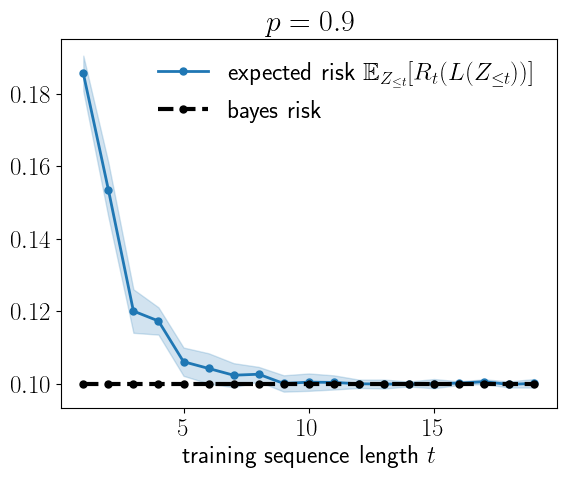

In [63]:
fig, ax = plt.subplots()
color = sns.color_palette("tab10")[0]
ax.plot(t_list[:-1], expected_future_risks, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ax.plot(t_list[:-1], bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')
ci = np.array(std) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list[:-1], expected_future_risks-ci, expected_future_risks+ci, color=color, alpha=0.2)
ax.set_xlabel(r'training sequence length $t$')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
plt.show()

In [64]:
# save
fig.savefig("figures/case1.pdf", bbox_inches='tight')

### Case 2: Independent

#### sub-case 1: Learner is aware of the alternating frequency and distributional sturcture (p, 1-p)

In [52]:
def sample_from_process(p, q, start, size=None):
    order = [p, q] if start % 2 else [q, p]
    if len(size) == 1:
        t = size[0]
        p_list = order * (t // 2)
        if t % 2:
            p_list.append(order[0])
        return np.random.binomial(n=1, p=p_list)
    else:
        t = size[1]
        p_list = order * (t // 2)
        if t % 2:
            p_list.append(order[0])
        return np.random.binomial(n=1, p=np.ones(size) * p_list)

def compute_p_hat(data):
    tmp = data[1::2]
    data[1::2] = 1-tmp
    return np.mean(data)

def hypothesis(p_hat_t, start, size):
    h = np.random.uniform(low=0, high=1, size=size)
    out = int(p_hat_t > 0.5)
    if start % 2:
        if p_hat_t != 0.5: h[:, 0::2], h[:, 1::2] = out, 1-out
    else:
        if p_hat_t != 0.5: h[:, 0::2], h[:, 1::2] = 1-out, out
    return h

In [53]:
p = 0.9
q = 1 - p
T = 20
t_list = np.arange(1, T+1, 1)
expected_future_risks_1 = []
std_1 = []
for t in t_list:
    if t == T:
        break
    tmp = []
    # randomly sample a training set
    for _ in range(2000):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))

        # compute the MLE for p
        p_hat_t = compute_p_hat(past_data)

        # sample 500 replicates of the future sequence of length 100
        size = (1000, T-t)
        future_data = sample_from_process(p, q, start=t+1, size=size)

        # evaluate the hypothesis on each of the 500 replicate sequences
        cumulative_losses = np.mean((future_data - hypothesis(p_hat_t, t+1, size))**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)

        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_1.append(np.mean(tmp))
    std_1.append(np.std(tmp))

# bayes_risk = (1-p)*np.arange(T-1, 0, -1)
bayes_risk = (1-p)*np.ones((T-1,))

#### Sub-case 2: Learner is aware of the alternating frequency and distributional structure (p, q)

In [54]:
def sample_from_process(p, q, start, size=None):
    order = [p, q] if start % 2 else [q, p]
    if len(size) == 1:
        t = size[0]
        p_list = order * (t // 2)
        if t % 2:
            p_list.append(order[0])
        return np.random.binomial(n=1, p=p_list)
    else:
        t = size[1]
        p_list = order * (t // 2)
        if t % 2:
            p_list.append(order[0])
        return np.random.binomial(n=1, p=np.ones(size) * p_list)

def compute_params(data):
    tmp1 = data[0::2]
    tmp2 = data[1::2]
    p_hat = np.mean(tmp1)
    q_hat = 0.5 if len(tmp2)==0 else np.mean(tmp2)
    return p_hat, q_hat

def hypothesis(p_hat_t, q_hat_t, start, size):
    h = np.random.uniform(low=0, high=1, size=size)
    out_p = int(p_hat_t > 0.5)
    out_q = int(q_hat_t > 0.5)
    if start % 2:
        if p_hat_t != 0.5: h[:, 0::2] = out_p 
        if q_hat_t != 0.5: h[:, 1::2] = out_q
    else:
        if q_hat_t != 0.5: h[:, 0::2] = out_q
        if p_hat_t != 0.5: h[:, 1::2] = out_p
    return h

In [55]:
p = 0.9
q = 1 - p
T = 20
t_list = np.arange(1, T+1, 1)
expected_future_risks_2 = []
std_2 = []
for t in t_list:
    if t == T:
        break
    tmp = []
    # randomly sample a training set
    for _ in range(2000):
        # sample a t-length sequence
        past_data = sample_from_process(p, q, start=1, size=(t,))

        # compute the MLE for p
        p_hat_t, q_hat_t = compute_params(past_data)

        # sample 500 replicates of the future sequence of length 100
        size = (1000, T-t)
        future_data = sample_from_process(p, q, start=t+1, size=size)

        # evaluate the hypothesis on each of the 500 replicate sequences
        cumulative_losses = np.mean((future_data - hypothesis(p_hat_t, q_hat_t, t+1, size))**2, axis=-1)

        # compute the integrated risk divided by future duration
        future_risk = np.mean(cumulative_losses)

        tmp.append(future_risk)
    
    # compute the expected integrated risk by averaging out the randomness of training data 
    expected_future_risks_2.append(np.mean(tmp))
    std_2.append(np.std(tmp))

# bayes_risk = (1-p)*np.arange(T-1, 0, -1)
bayes_risk = (1-p)*np.ones((T-1,))

#### Sub-case 3: Learner is aware of the distributional structure (p, q), but not the alternating frequency

In [47]:
sns.color_palette("tab10")

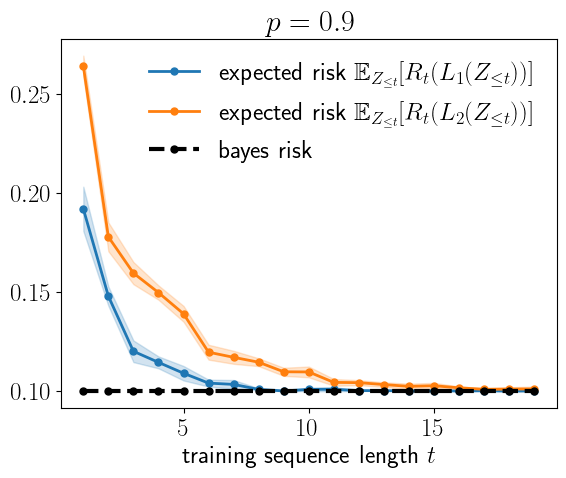

In [65]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab10")

color = colors[0]
ax.plot(t_list[:-1], expected_future_risks_1, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_1(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_1) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list[:-1], expected_future_risks_1-ci, expected_future_risks_1+ci, color=color, alpha=0.2)

color = colors[1]
ax.plot(t_list[:-1], expected_future_risks_2, 
         label=r'expected risk $\mathbb{E}_{Z_{\leq t}}[R_t(L_2(Z_{\leq t}))]$', 
         color=color, marker='o', ms=5, lw=2)
ci = np.array(std_2) * 1.96 / np.sqrt(reps)
ax.fill_between(t_list[:-1], expected_future_risks_2-ci, expected_future_risks_2+ci, color=color, alpha=0.2)

ax.plot(t_list[:-1], bayes_risk, lw=3, marker='o', ls='dashed', ms=5, color='k', label='bayes risk')

ax.set_xlabel(r'training sequence length $t$')
ax.set_title(fr"$p = {p}$")
ax.legend(frameon=False)
plt.show()

In [66]:
# save
fig.savefig("figures/case2.pdf", bbox_inches='tight')

### Case 3: Dependent

In [60]:
def hypothesis():
    return 1

p = 0.8
T = 10

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []
cumulative_losses = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):
    # get the cumulative loss for each outcome
    cumulative_loss = np.sum((outcomes[:, t:].astype('int') != hypothesis()), axis=-1)
    cumulative_losses.append(cumulative_loss)
    
    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

cumulative_losses = np.array(cumulative_losses)

Text(0.5, 1.0, 'p = 0.8')

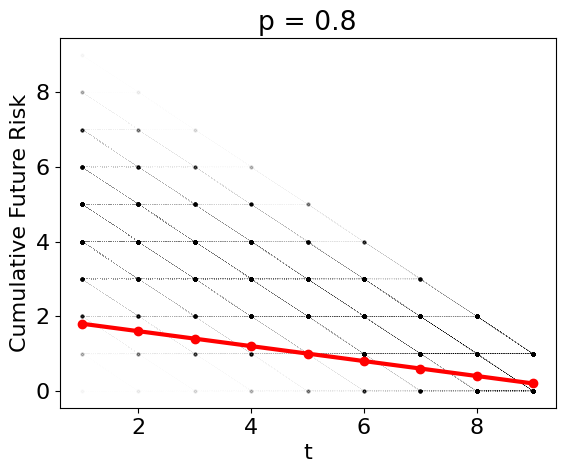

In [62]:
plt.plot(np.arange(1, T, 1), cumulative_losses, ls='dotted', marker='o', alpha=0.01, color='k', lw=0.5, ms=2)
plt.plot(np.arange(1, T, 1), future_risk_beyond_t, color='r', lw=3, marker='o')
plt.xlabel('t')
plt.ylabel(r'Cumulative Future Risk') # + '\n' + r'$R_t(h_{\geq t})$')
plt.title(f"p = {p}")

In [80]:
def hypothesis(p_hat):
    return (p_hat > 0.5).astype('int')

p = 0.8
T = 20 # length of the process being considered

# list all possible outcomes of the process
outcomes = np.array(list(map(list, itertools.product([0, 1], repeat=T)))).astype('float')

# compute the probability of each outcome using the product measure (due to iid assumption)
probs = np.copy(outcomes)
probs[probs == 1] = p
probs[probs == 0] = 1-p
prob_weight = np.prod(probs, axis=-1)

t_list = np.arange(1, T+1, 1)
future_risk_beyond_t = []

# loop over increasing values of t
for t in range(1, len(t_list), 1):

    # get the past (training) data at each outcome
    past_outcomes = outcomes[:, :t]

    # get the future (evaluation) data at each outcome
    future_outcomes = outcomes[:, t:]

    # compute the p_hat at each outcome based on past data
    p_hat = np.mean(past_outcomes, axis=-1)

    # get the hypothesis for each outcome
    h = np.repeat(hypothesis(p_hat).reshape(-1, 1), len(t_list)-t, axis=-1)

    # get the cumulative loss for each outcome
    cumulative_loss = np.mean((future_outcomes.astype('int') != h), axis=-1)

    # take the weighted average of the cumulative loss over all the outcomes (weight is the probabilities we computed above)
    expected_cumulative_loss = np.average(cumulative_loss, weights=prob_weight)
    future_risk_beyond_t.append(expected_cumulative_loss)

Text(0.5, 1.0, 'p = 0.8')

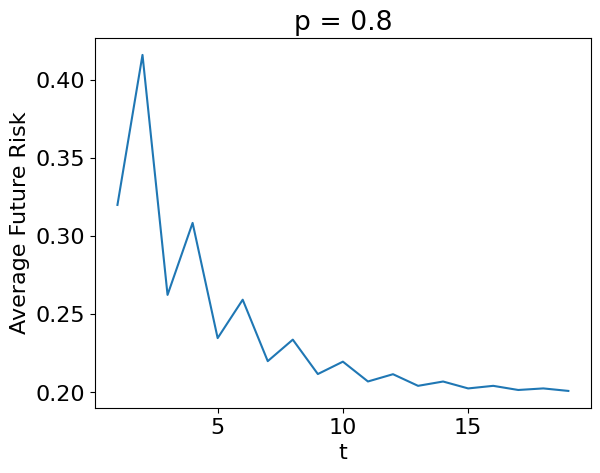

In [81]:
plt.plot(np.arange(1, T, 1), future_risk_beyond_t)
plt.xlabel('t')
plt.ylabel(r'Average Future Risk')
plt.title(f"p = {p}")

In [27]:
def get_p_hat(seq, alpha=2, beta=2):
    return np.divide(alpha + np.sum(seq) - 1, alpha + beta + len(seq) - 2)

def hypothesis(p_hat, size):
    if p_hat > 0.5:
        return 1
    elif p_hat < 0.5:
        return 0
    else:
        return np.random.uniform(low=0, high=1, size=size)
    
p = 0.8
T = 10
t_list = np.arange(1, T+1, 1)

conditional_risks_for_several_outcomes = []
outcomes = []
for _ in range(5):
    # sample an outcome (sequence) from the process
    outcome_from_the_process = np.random.binomial(n=1, p=p*np.ones(T))
    outcomes.append(outcome_from_the_process)

    conditional_average_future_risk = []
    for t in t_list:
        if t == T:
            break
        # compute p_hat based on the first t samples of the sequence
        p_hat = get_p_hat(outcome_from_the_process[:t])

        # sample replicates of the future sequence of length T-t (future distribution doesn't depend on the past, so no effect from the past data here)
        size = (1000, T-t)
        future_data = np.random.binomial(n=1, p=p*np.ones(size))

        # compute the average future loss on each of the replicate future sequences
        average_future_loss = np.sum((future_data - hypothesis(p_hat, size))**2, axis=-1)

        # compute the average future risk
        average_future_risk = np.mean(average_future_loss)

        conditional_average_future_risk.append(average_future_risk)
    conditional_risks_for_several_outcomes.append(conditional_average_future_risk)
    
conditional_risks_for_several_outcomes = np.array(conditional_risks_for_several_outcomes).T

bayes_cumulative_error = []
for t in t_list:
    if t == T:
        break
    bayes_cumulative_error.append(np.sum(0.2 * np.ones((T-t,))))

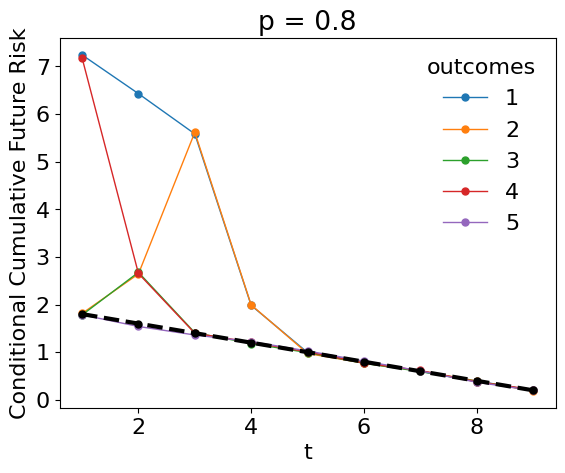

In [33]:
plt.plot(t_list[:-1], conditional_risks_for_several_outcomes, lw=1, marker='o', ms=5)
plt.plot(t_list[:-1], bayes_cumulative_error, lw=3, marker='o', ls='dashed', ms=5, color='k', label='Bayes Error')
plt.xlabel('t')
plt.ylabel(r'Conditional Cumulative Future Risk')
plt.title(f"p = {p}")
plt.legend(np.arange(1, 6, 1), title='outcomes', frameon=False)